In [1]:
%load_ext autoreload
%autoreload 2
import warnings
import numpy as np
import time
import os
from dotenv import load_dotenv
os.environ["USE_PYGEOS"] = "0"
import napari_sparrow as nas
from spatialdata import read_zarr
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import sample 
import scanpy as sc
import seaborn as sns
import anndata as ad
%run own_and_modified_functions.ipynb
warnings.simplefilter(action='ignore')

the value of the environment variable BASIC_DCT_BACKEND is not in ["JAX","SCIPY"]


In [2]:
OUTPUT_DIR = '/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data/A1-1'
#sdata = read_zarr( os.path.join(  OUTPUT_DIR, 'sdata.zarr'  ) )
name_anndata = "anndataNucA11"
sample = "A11"
anndata = sc.read(OUTPUT_DIR + '/' + name_anndata + '_all_Q1threshold') # get original anndata after Sparrow

In [3]:
anndata.obs.columns

Index(['region', 'instance', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_2_genes',
       'pct_counts_in_top_5_genes', 'n_counts', 'shapeSize',
       ...
       'annotation_own_score_genes_HLMartin_7',
       'annotation_own_score_genes_start_iterative_HLMartin_7',
       'annotation_score_genes_original_BasicMartin_updated_7',
       'annotation_own_score_genes_BasicMartin_updated_7',
       'annotation_own_score_genes_start_iterative_BasicMartin_updated_7',
       'annotation_score_genes_original_HLMartin_updated_7',
       'annotation_own_score_genes_HLMartin_updated_7',
       'annotation_own_score_genes_start_iterative_HLMartin_updated_7',
       'annotation_tangram_11', 'annotation_tangram_7'],
      dtype='object', length=144)

Meso
[]
Fibr
[(31, 0.81, 118, 'Fibr', 0.0)]
Hepa
[(2, 0.98, 164, 'Hepa', 0.0)]
Kupf
[(6, 1.0, 146, 'Kupf', 0.0)]
LSEC
[(0, 0.99, 172, 'LSEC', 0.0)]
B cell
[(82, 1.0, 76, 'B cell', 0.0)]
Central vein
[(92, 0.98, 66, 'Central vein', 0.0)]
Stel
[(8, 1.0, 141, 'Stel', 0.0)]
Portal vein
[(10, 1.0, 137, 'Portal vein', 0.0)]
Chol
[(25, 0.98, 123, 'Chol', 0.0)]
Portal LAM
[]
Oth im
[(1, 0.74, 171, 'Oth im', 0.0)]
Unknown
[(36, 0.36, 115, 'Portal vein', 0.0), (59, 0.34, 93, 'Kupf', 0.0), (100, 0.49, 59, 'Oth im', 0.0), (102, 0.34, 58, 'Unknown', 0.34), (108, 0.38, 42, 'Portal LAM', 0.0), (111, 0.5, 38, 'LSEC', 0.0)]


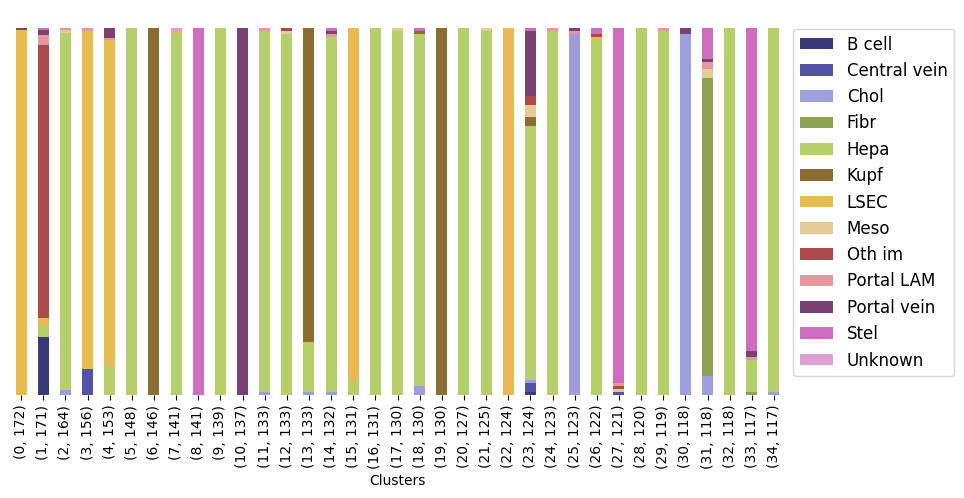

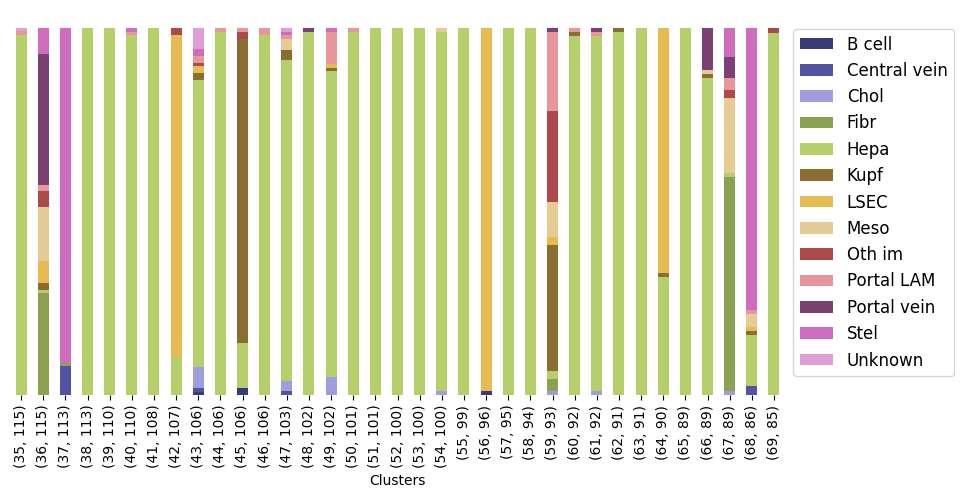

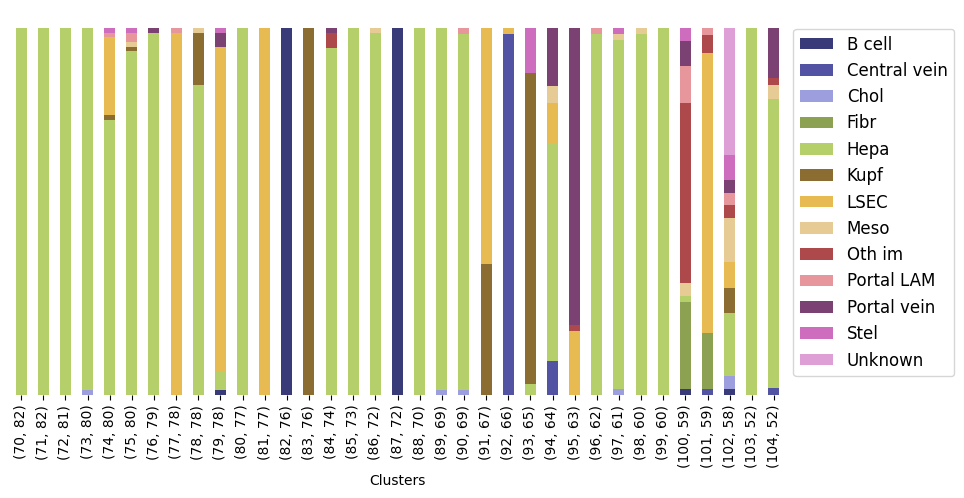

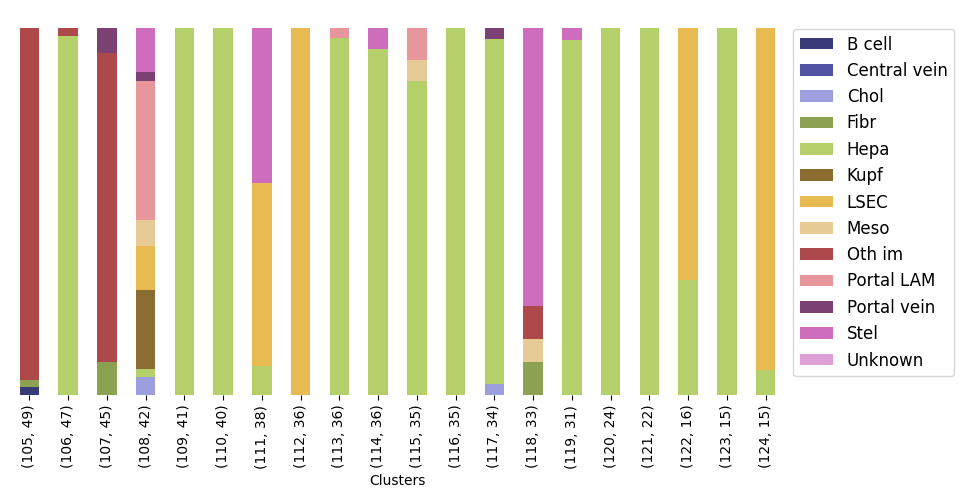

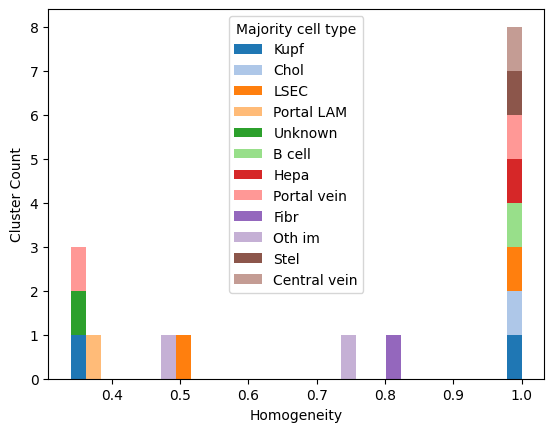

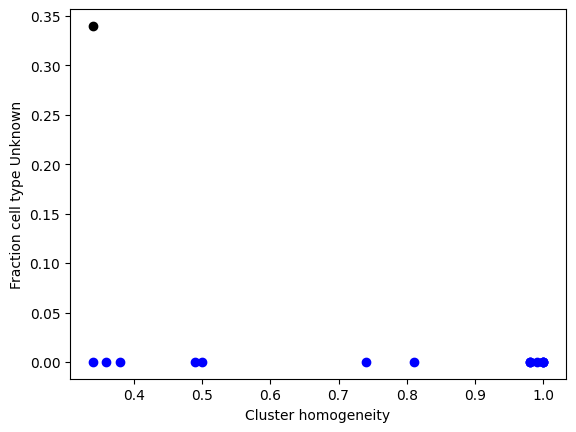

In [4]:
miniLeiden = clusteringVSleiden(anndata,'annotation_own_score_genes_Atlas_Scores_12','leiden')

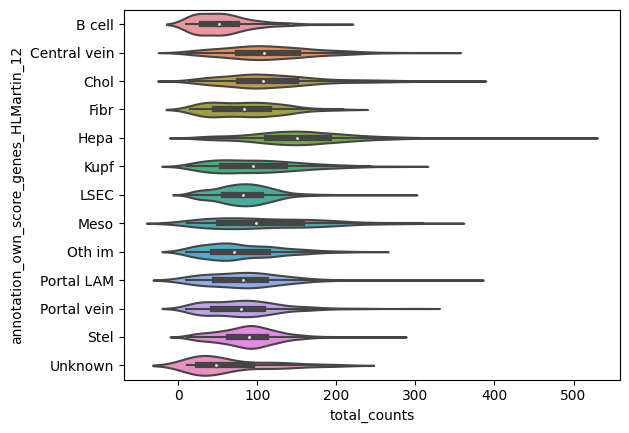

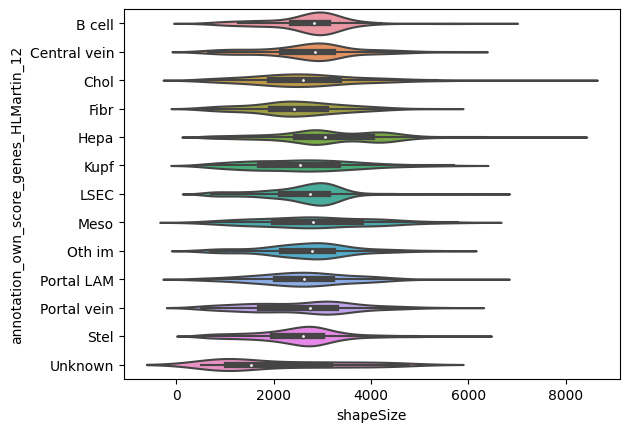

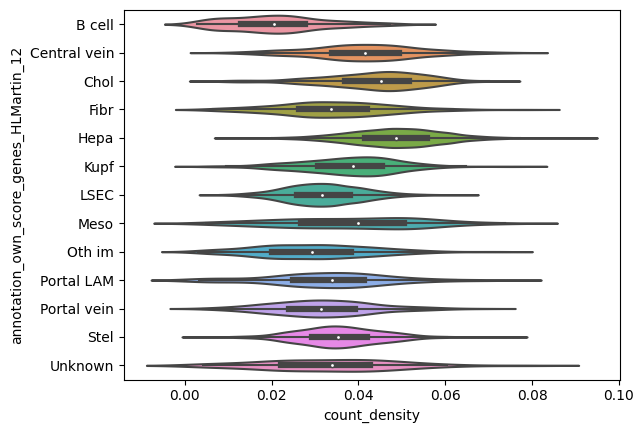

In [7]:
annotation = 'annotation_own_score_genes_HLMartin_12'
sns.violinplot(data=anndata.obs,x="total_counts",y=annotation)
plt.show()
sns.violinplot(data=anndata.obs,x="shapeSize",y=annotation)
plt.show()
anndata.obs['count_density'] = anndata.obs['total_counts'] / anndata.obs['shapeSize']
sns.violinplot(data=anndata.obs,x="count_density",y=annotation)
plt.show()